In [2]:
# Libraries 
import sys
import glob
import h5py
import yaml
import copy
import shap
import torch
import logging
import warnings
import scipy.io 
import argparse
import os, random
import numpy as np 
import pandas as pd
import torch.nn as nn
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from collections import defaultdict
from captum.attr import IntegratedGradients
from scipy.stats import ttest_rel, wilcoxon
from typing import List, Dict , Tuple, Optional
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from config import Config, set_seed, setup_logging
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Dataset, DataLoader,  Subset
from scipy.stats import ttest_rel, wilcoxon, t as t_dist
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [3]:
#Others imports 
import math
from crossmodal_v4_enhancements import (
    EnhancedTriModalFusionNetV4,
    EnhancedSmartFusionNetV4,
    EnhancedERPEncoder,
    EnhancedPowerEncoder,
    LearnedFusionModule,
    get_fusion_weights_from_model,
    count_parameters
)

CrossModal V4 Enhancements Module Loaded

Available classes:
  - EnhancedTriModalFusionNetV4 (tri-modal: ERP + PW + Connectivity)
  - EnhancedSmartFusionNetV4 (bi-modal: ERP + PW, with cross-attention)
  - BiDirectionalCrossAttention (NEW: mutual cross-modal attention)
  - EnhancedERPEncoder (1D CNN + temporal transformers)
  - EnhancedPowerEncoder (multi-scale CNN + transformers)
  - LearnedFusionModule (learned fusion weights with temperature)

Utility functions:
  - get_fusion_weights_from_model(model)
  - count_parameters(model)

V4.1 Updates:
  - Bi-modal now has bi-directional cross-modal attention
  - Increased dropout (0.3 -> 0.4) for small datasets
  - Deeper classifier head matching tri-modal


V4-LITE Components for Small Datasets Added

New classes for improved trimodal performance:
  - EnhancedTriModalFusionNetV4Lite (lightweight, ~400K params)
  - BalancedTriModalDataset (handles sample count mismatch)
  - HybridFusionModule (early ERP-PW + late CONN fusion)
  - EnhancedC

In [4]:
# data path and subject setup
#base_path = Path(r'E:\Intermediate\BACON_ERIC\Head_neck')
base_path= Path(r'E:\Head_neck')
eeg_path_pw   = base_path / 'EEG' / 'DATA' / 'PROC' / 'data_proc' / 'cleaned_data' / 'TF_dir' / 'pwspctrm' / 'PWS' /'feat' #/'New'

eeg_path_erp  = base_path / 'EEG' / 'DATA' / 'PROC' / 'data_proc' / 'cleaned_data' / 'TF_dir' / 'ERP' / 'New'
eeg_path_conn  = base_path / 'EEG' / 'DATA' / 'PROC' / 'data_proc' / 'cleaned_data' / 'conn_dir' #/ 'CONN' 

#label_path  = base_path / 'EEG' / 'DATA' / 'PROC' / 'data_proc' / 'cleaned_data' / 'TF_dir'
label_path = base_path / 'EEG' / 'DATA' / 'PROC' / 'data_proc' / 'cleaned_data' / 'TF_dir'

subject_list=[ 1, 2,3, 4 ,5,6,7,8,9, 10 , 11, 12 ,13, 14, 15, 16, 17 , 18 , 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,29, 30,  31,  32, 33, 34, 35, 36, 37, 38, 39,40,
               41,42,43, 44, 45,46, 47, 48, 49, 50,51,   52, 53, 54, 55, 56,57, 58, 59, 60, 61, 62, 63] 

bands = {'alpha': 'Alpha', 'beta': 'Beta', 'theta': 'Theta'}
eeg_segments = ['1_Hz','2_Hz','4_Hz','6_Hz','8_Hz','10_Hz','12_Hz','14_Hz','16_Hz','18_Hz','20_Hz','25_Hz', '30_Hz', '40_Hz']
func_segments = ['open', 'close']

In [5]:
# Labels mapping
df_label = pd.read_csv(os.path.join(label_path, 'medical_score.csv'))
df_label = df_label.dropna(subset=['Postoperative evaluation'])
df_label["subject"] = df_label["Subject"].str.replace("sub", "").astype(int)
unique_scores = sorted(df_label['Postoperative evaluation'].unique())
score_to_class = {s: i for i, s in enumerate(unique_scores)}
label_dict = {}
for idx, row in df_label.iterrows():
    subj = int(row["subject"])
    score = row['Postoperative evaluation']
    if score <= 2:
        label_dict[subj] = 0
    else:
        label_dict[subj] = 1

vals = list(label_dict.values())
n_0, n_1 = vals.count(0), vals.count(1)
print(f"New Binary Balance: {n_0} vs {n_1}")

New Binary Balance: 35 vs 31


In [6]:
# Utilities
def pad_or_truncate_1d(x, target_len, pad_value=0.0):
    L = x.shape[0]
    if L == target_len:
        return x
    if L < target_len:
        pad = np.full((target_len - L,), pad_value, dtype=x.dtype)
        return np.concatenate([x, pad], axis=0)
    else:
        return x[:target_len]

def pad_or_truncate_2d(x, target_len, axis=1, pad_value=0.0):
    if axis != 1:
        raise NotImplementedError
    C, T = x.shape
    if T == target_len:
        return x
    if T < target_len:
        pad = np.full((C, target_len - T), pad_value, dtype=x.dtype)
        return np.concatenate([x, pad], axis=1)
    else:
        return x[:, :target_len]

def mat_get_field(obj, key):
    if isinstance(obj, dict):
        return obj[key]
    return getattr(obj, key)

def normalize_modality(feat, eps=1e-8):
    mean = np.mean(feat, axis=None, keepdims=True)
    std  = np.std(feat, axis=None, keepdims=True)
    return (feat - mean) / (std + eps)

def vec_upper_triangle(mat):
    iu = np.triu_indices(mat.shape[0], k=1)
    return mat[iu]

In [7]:
class BaseEEGModel(nn.Module):
    def forward(self, erp: Optional[torch.Tensor] = None, 
                pw: Optional[torch.Tensor] = None,
                return_feats: bool = False) -> torch.Tensor:
        raise NotImplementedError

In [8]:
# Connectivity data features
class EEGDatasetCONN(Dataset):
    def __init__(self, subj_list: List[int], band_list: Dict, cond_list: List[str],
                 conn_dir: Path, labels: Optional[Dict] = None, verbose: bool = True,
                 normalize: bool = True, logger: Optional[logging.Logger] = None):
        self.samples = []
        self.labels = labels or {}
        self.verbose = verbose
        self.normalize = normalize
        self.conn_dir = Path(conn_dir)
        self.logger = logger or logging.getLogger(__name__)
        self._load_data(subj_list, band_list, cond_list)

    def _load_data(self, subj_list: List[int], band_list: Dict, cond_list: List[str]):
        for subj in subj_list:
            subj_str = f"{subj:02d}"
            for band_key, band_name in band_list.items():
                for cond in cond_list:
                    pattern = self.conn_dir / f"conn_{band_name}_{cond}_sub{subj_str}.mat"
                    files = sorted(glob.glob(str(pattern)))
                    if not files:
                        pattern_lower = self.conn_dir / f"conn_{band_key}_{cond}_sub{subj_str}.mat"
                        files = sorted(glob.glob(str(pattern_lower)))
                    for f in files:
                        try:
                            feat = self._load_conn_flat(f)
                            label = self.labels.get(subj, -1)
                            self.samples.append((feat, subj, band_key, cond, label))
                            if self.verbose:
                                self.logger.info(f"Loaded {Path(f).name} | shape={feat.shape}")
                        except Exception as e:
                            self.logger.warning(f"Skipping {f}: {e}")
                            
    def _load_conn_flat(self, path: str) -> np.ndarray:
        try:
            mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
            conn = mat.get('conn', mat)
            PLV = np.array(conn.PLV, dtype=np.float32)
            COH = np.array(conn.COH, dtype=np.float32)
            WPLI = np.array(conn.WPLI, dtype=np.float32)
            plv_vec = vec_upper_triangle(PLV)
            coh_vec = vec_upper_triangle(COH)
            wpli_vec = vec_upper_triangle(WPLI)
            feat = np.concatenate([plv_vec, coh_vec, wpli_vec], axis=0)
            if self.normalize:
                feat = (feat - feat.mean()) / (feat.std() + 1e-8)
            return feat
        except Exception as e:
            raise RuntimeError(f"Failed to load connectivity from {path}: {e}")
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple:
        feat, subj, band, cond, y = self.samples[idx]
        return torch.tensor(feat, dtype=torch.float32), subj, band, cond, y

In [9]:
#Pwctrm features extraction
class EEGDatasetPW(Dataset):  
    def __init__(self, subj_list: List[int], band_list: Dict, freq_list: List[str],
                 pw_dir: Path, labels: Optional[Dict] = None, verbose: bool = True,
                 normalize: bool = True, logger: Optional[logging.Logger] = None):
        self.samples = []
        self.labels = labels or {}
        self.verbose = verbose
        self.normalize = normalize
        self.pw_dir = Path(pw_dir)
        self.logger = logger or logging.getLogger(__name__) 
        self._load_data(subj_list, band_list, freq_list)
    
    def _load_data(self, subj_list: List[int], band_list: Dict, freq_list: List[str]):
        for subj in subj_list:
            subj_str = f"{subj:02d}"
            for band in band_list:
                for freq in freq_list:
                    pattern = str(self.pw_dir / f"powspctrm_{band}_{freq}_sub{subj_str}.mat")
                    for f in sorted(glob.glob(pattern)):
                        try:
                            feat_mat = self._load_pw_flat(f)
                            label = self.labels.get(subj, -1)
                            self.samples.append((feat_mat, subj, band, freq, label))
                            if self.verbose:
                                self.logger.info(f"Loaded {f}: {feat_mat.shape}")
                        except Exception as e:
                            self.logger.warning(f"Skipping {f}: {e}")
    
    def _load_pw_flat(self, path: str) -> np.ndarray:
        try:
            mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
            pw_s = mat.get('powspctrm', None)
            if pw_s is None:
                for k in mat:
                    if 'powspctrm' in k.lower():
                        pw_s = mat[k]
                        break
                if pw_s is None:
                    raise KeyError("'powspctrm' not found in file")
            Pw = self._get_field(pw_s, 'Pw')
            Pw = np.array(Pw)
            if Pw.ndim != 3:
                raise ValueError(f"Pw must be (C,F,T), got {Pw.shape}")
            C, F, T = Pw.shape
            Pw_fair = Pw.transpose(0,1,2).reshape(C*F, T)
            #Pw_flat = Pw.reshape(C, F * T).astype(np.float32) 
            if self.normalize:
                mu = Pw_fair.mean(axis=1, keepdims=True)
                sd = Pw_fair.std(axis=1, keepdims=True)
                sd = np.where(sd == 0, 1.0, sd)
                Pw_flat = (Pw_fair - mu) / sd 
            return Pw_fair
        except Exception as e:
            raise RuntimeError(f"Failed to load power spectrum from {path}: {e}")
    
    @staticmethod
    def _get_field(o, key: str):
        if isinstance(o, dict):
            return o[key]
        if hasattr(o, key):
            return getattr(o, key)
        if isinstance(o, np.ndarray) and o.dtype == object and o.size == 1:
            o = o.item()
            if hasattr(o, key):
                return getattr(o, key)
        raise KeyError(f"Cannot get field '{key}'")
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple:
        feat, subj, band, freq, y = self.samples[idx]
        return torch.tensor(feat, dtype=torch.float32), subj, band, freq, y

In [10]:
# PW Encoders blocks
class PowerEncoder(nn.Module):
    def __init__(self, in_channels: int, out_dim: int = 128, dropout: float = 0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.proj = nn.Conv1d(128, out_dim, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.proj(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1) 
        return x

In [11]:
#========== PW BASELINE ==========
class PWOnlyNet(BaseEEGModel):    
    def __init__(self, in_channels: int, pw_out: int = 128, hidden: int = 64, n_classes: int = 2):
        super().__init__()
        self.pw_enc = PowerEncoder(in_channels=in_channels, out_dim=pw_out)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(pw_out, hidden),
            nn.BatchNorm1d(hidden),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, n_classes)
        )
    
    def forward(self, erp: Optional[torch.Tensor] = None, pw: torch.Tensor = None,
                return_feats: bool = False) -> torch.Tensor:
        p = self.pw_enc(pw)
        if p.ndim == 3:
            p = p.permute(0, 2, 1)
        p = self.pool(p).squeeze(-1)
        return self.head(p)

In [12]:
# ERP Dataset
class EEGDatasetERP(Dataset):
    def __init__(self, subj_list: List[int], band_list: Dict, freq_list: List[str],
                 erp_dir: Path, labels: Optional[Dict] = None, verbose: bool = True,
                 target_len: Optional[int] = None, logger: Optional[logging.Logger] = None):
        self.samples = []
        self.labels = labels or {}
        self.target_len = target_len
        self.logger = logger or logging.getLogger(__name__)
        self._load_data(subj_list, band_list, freq_list, Path(erp_dir), verbose)
        if self.target_len is None and len(self.samples) > 0:
            self.target_len = max([s[0].shape[1] for s in self.samples])
            if verbose:
                self.logger.info(f"Auto target_len (ERP) = {self.target_len}")
        if verbose:
            self.logger.info(f"ERP Dataset loaded: {len(self.samples)} samples")
    
    def _load_data(self, subj_list: List[int], band_list: Dict, freq_list: List[str],
                   erp_dir: Path, verbose: bool):
        for subj in subj_list:
            subj_str = f"{subj:02d}"
            for band in band_list:
                for freq in freq_list:
                    pattern = erp_dir / f'ERP_sub{subj_str}_{band}_{freq}*.mat'
                    erp_files = sorted(glob.glob(str(pattern)))     
                    if len(erp_files) == 0:
                        if verbose:
                            self.logger.debug(f"No ERP file for subj={subj_str}, band={band}, freq={freq}")
                        continue
                    for erp_path in erp_files:
                        try:
                            ERP, chanlabels, epoch_time, _, _ = self.extract_erpfeat_from_file(erp_path)
                            label = self.labels.get(subj, -1)   
                            # Standardize to 2D
                            if ERP.ndim == 1:
                                ERP = ERP[np.newaxis, :]
                            elif ERP.ndim != 2:
                                self.logger.warning(f"Unexpected ERP shape {ERP.shape} in {erp_path}")
                                continue     
                            ERP = normalize_modality(ERP)
                            self.samples.append((ERP.astype(np.float32), subj, band, freq, 
                                               label, chanlabels, epoch_time))
                        except Exception as e:
                            self.logger.warning(f"Skipping {erp_path}: {e}")
    
    @staticmethod
    def extract_erpfeat_from_file(path: str) -> Tuple:
        """Extract ERP features from HDF5 file"""
        try:
            with h5py.File(path, 'r') as f:
                if 'erp_struct' in f:
                    erp = f['erp_struct']
                elif 'erp' in f:
                    erp = f['erp']
                else:
                    raise KeyError("ERP struct not found in file")
                if 'ERP' not in erp:
                    raise KeyError(f"No 'ERP' dataset found. Available keys: {list(erp.keys())}")
                ERP = np.array(erp['ERP']).T.astype(np.float32)
                
                # Extract channel labels
                chanlabels = []
                if 'chanlabels' in erp:
                    raw = np.array(erp['chanlabels'])
                    try:
                        for el in raw.flatten():
                            if isinstance(el, (bytes, str, np.str_)):
                                chanlabels.append(el.decode() if isinstance(el, bytes) else str(el))
                            else:
                                ref = el
                                if isinstance(ref, h5py.Reference):
                                    chars = ''.join(chr(c) for c in np.array(f[ref]).flatten())
                                    chanlabels.append(chars)
                    except Exception:
                        chanlabels = [f"ch{i}" for i in range(ERP.shape[0])]
                else:
                    chanlabels = [f"ch{i}" for i in range(ERP.shape[0])] 
                epoch_time = (np.array(erp['epoch_time']).squeeze() 
                            if 'epoch_time' in erp else np.arange(ERP.shape[1]))
                subj_meta = erp['subj'][()] if 'subj' in erp else None
                band_meta = erp['band'][()] if 'band' in erp else None    
                return ERP, chanlabels, epoch_time, subj_meta, band_meta
        except Exception as e:
            raise RuntimeError(f"Failed to extract ERP from {path}: {e}")
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple:
        ERP, subj, band, freq, y, chanlabels, epoch_time = self.samples[idx]     
        if self.target_len is not None:
            ERP = pad_or_truncate_2d(ERP, self.target_len, axis=1) 
        feat_tensor = torch.tensor(ERP, dtype=torch.float32)
        return feat_tensor, subj, band, freq, y, chanlabels, epoch_time

In [13]:
# Connectivity aggregation
def aggregate_conn_features(dataset, agg="mean"):
    grouped = defaultdict(list)
    print(f"Aggregating {len(dataset)} CONN samples...")
    for feat, subj, band, cond, y in dataset.samples:
        k_subj = int(subj)
        k_band = str(band).lower()
        k_cond = str(cond).lower()
        k_y = int(y)
        grouped[(k_subj, k_band, k_cond, k_y)].append(np.array(feat, dtype=np.float32))
    agg_conn_features = {}
    for key, feats in grouped.items():
        feats = np.stack(feats, axis=0)
        if agg == "mean":
            agg_feat = feats.mean(axis=0)
        elif agg == "median":
            agg_feat = np.median(feats, axis=0)
        elif agg == "concat":
            agg_feat = feats.reshape(-1)
        agg_conn_features[key] = agg_feat

    return agg_conn_features

# Aggregate pwstrm 
def aggregate_pw_features(dataset, agg="mean"):
    grouped = defaultdict(list)
    for feat, subj, band, freq, y in dataset.samples:
        grouped[(int(subj), band, freq, int(y))].append(np.array(feat, dtype=np.float32))
    agg_pw_features = {}
    for key, feats in grouped.items():
        feats = np.stack(feats)
        if agg == "mean":
            agg_feat = feats.mean(axis=0)
        elif agg == "median":
            agg_feat = np.median(feats, axis=0)
        elif agg == "concat":
            agg_feat = np.concatenate(feats, axis=0)
        else:
            raise ValueError(f"Unknown aggregation '{agg}'")
        agg_pw_features[key] = agg_feat
    return agg_pw_features

# Aggregate ERP data 
def aggregate_erp_features(dataset, agg="mean"):
    grouped = defaultdict(list)
    for feat, subj, band, freq, y, chanlabels, epoch_time in dataset.samples:
        arr = np.array(feat, dtype=np.float32)  
        arr = arr.T  
        grouped[(int(subj), band, freq, int(y))].append(arr)
    agg_erp_features = {}
    for key, feats in grouped.items():
        feats = np.stack(feats) 
        if agg == "mean":
            agg_feat = feats.mean(axis=0) 
        elif agg == "median":
            agg_feat = np.median(feats, axis=0)
        elif agg == "concat":
            agg_feat = feats.reshape(-1, feats.shape[-1]) 
        else:
            raise ValueError(f"Unknown aggregation {agg}")
        agg_erp_features[key] = agg_feat
    return agg_erp_features

In [14]:
# ERP Encoder 
class ERPEncoder(nn.Module):
    def __init__(self, in_channels: int = 18, out_dim: int = 128, dropout: float = 0.2):
        super().__init__()
        self.out_dim = out_dim
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(2)
        self.step_proj = nn.Conv1d(128, out_dim, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.step_proj(x)
        x = x.permute(0, 2, 1)
        return x

In [15]:
# ======== ERP BASELINE =========
class ERPOnlyNet(BaseEEGModel): 
    def __init__(self, in_dim: int, erp_out: int = 128, hidden: int = 64, n_classes: int = 2):
        super().__init__()
        self.erp_enc = ERPEncoder(in_channels=in_dim, out_dim=erp_out)
        self.pool = nn.AdaptiveAvgPool1d(4)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(erp_out * 4, hidden),
            nn.BatchNorm1d(hidden),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(hidden, n_classes)
        )
    
    def forward(self, erp: torch.Tensor, pw: Optional[torch.Tensor] = None,
                return_feats: bool = False) -> torch.Tensor:
        if erp.dim() == 3 and erp.shape[1] > erp.shape[2]:
            erp = erp.permute(0, 2, 1).contiguous()
        e = self.erp_enc(erp)
        e = e.permute(0, 2, 1)
        e = self.pool(e)
        return self.head(e)

In [16]:
# Augmentation & Fusion data 
class EEGTransforms:
    def __init__(self, p: float = 0.3, noise_factor: float = 0.05):
        self.p = p
        self.noise_factor = noise_factor
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.clone()  
        if torch.rand(1) < self.p:
            noise = torch.randn_like(x) * self.noise_factor * x.std()
            x += noise
        if x.dim() > 0 and torch.rand(1) < self.p:
            num_channels = x.shape[0]
            n_drop = max(1, int(0.1 * num_channels))  
            drop_channels = torch.randperm(num_channels)[:n_drop]
            x[drop_channels, ...] = 0
        return x

class FusionDataset(Dataset) :
    def __init__(self, erp_features: Dict, pw_features: Dict, label_dict: Dict,
                 transform: Optional[EEGTransforms] = None, verbose: bool = True,
                 logger: Optional[logging.Logger] = None):
        self.samples = []
        self.transform = transform
        self.logger = logger or logging.getLogger(__name__)
        for key in erp_features.keys():
            subj, band, freq, label = key
            if (subj, band, freq, label) not in pw_features:
                continue
            if subj not in label_dict:
                continue  
            erp_feat = erp_features[key]
            pw_feat = pw_features[key]
            clinical_score = label_dict[subj]   
            self.samples.append((erp_feat, pw_feat, subj, clinical_score))
        if verbose:
            self.logger.info(f"Fusion Dataset: {len(self.samples)} matched ERP+PW+Label samples")
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple:
        erp_mat, pw_mat, subj, y = self.samples[idx] 
        erp_tensor = torch.tensor(erp_mat, dtype=torch.float32)
        pw_tensor = torch.tensor(pw_mat, dtype=torch.float32)
        if self.transform is not None:
            erp_tensor = self.transform(erp_tensor)
            pw_tensor = self.transform(pw_tensor)
        return erp_tensor, pw_tensor, int(subj), int(y)

In [17]:
# Load aggregate and experiment setup
def load_and_aggregate(name, dataset_cls, data_dir, config, labels, logger, agg_method="mean", **kwargs):
    logger.info(f"Loading {name} data from {data_dir}...")
    init_params = {
        'subj_list': config.subject_list,
        'band_list': config.bands,
        'labels': labels,
        'verbose': False,
        'logger': logger
    }
    if name == 'CONN':
        init_params['cond_list'] = config.func_segments
        init_params['conn_dir'] = data_dir
    elif name == 'PW':
        init_params['freq_list'] = config.eeg_segments
        init_params['pw_dir'] = data_dir
    elif name == 'ERP':
        init_params['freq_list'] = config.eeg_segments
        init_params['erp_dir'] = data_dir
    init_params.update(kwargs)
    ds = dataset_cls(**init_params)
    logger.info(f"Loaded {len(ds)} {name} samples")
    if name == 'CONN':
        feats = aggregate_conn_features(ds, agg=agg_method)
    elif name == 'PW':
        feats = aggregate_pw_features(ds, agg=agg_method)
    elif name == 'ERP':
        feats = aggregate_erp_features(ds, agg=agg_method)
        print(feats)
    logger.info(f"Aggregated {name}: {len(feats)} samples")
    return feats

def setup_experiment(config_path):
    print("="*70)
    print("EEG MULTIMODAL FUSION PIPELINE")
    print("="*70)
    config = Config(config_path)
    config.output_dir.mkdir(parents=True, exist_ok=True)
    config.save_config(config.output_dir / 'config.yaml')
    logger = setup_logging(config.log_dir, name='eeg_main')
    logger.info("Configuration loaded successfully")
    set_seed(42)
    logger.info("Random seeds set")
    return config, logger

In [18]:
def load_labels(label_dir, binary=True):
    csv_path = os.path.join(label_dir, 'medical_score.csv')
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Label file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['Postoperative evaluation'])
    if df['Subject'].dtype == object:
        df["subject_id"] = df["Subject"].str.replace("sub", "", regex=False).astype(int)
    else:
        df["subject_id"] = df["Subject"].astype(int)
    label_dict = {}
    for idx, row in df.iterrows():
        subj = int(row["subject_id"])
        score = row['Postoperative evaluation']
        if binary:
            label_dict[subj] = 0 if score <= 2 else 1
        else:
            label_dict[subj] = score

    return label_dict

In [ ]:
# ========== SUBJECT DATA HANDLER ==========
class SubjectDataHandler:
    """Centralizes label loading, feature aggregation, normalization,
    splitting, and per-subject tracking for LOSO and kfold evaluation."""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.label_dict = {}
        self.erp_features = {}
        self.pw_features = {}
        self.conn_features = {}
        self.subject_ids = []
        self.subject_labels = {}

    # ----- label loading -----
    def load_labels(self, binary=True):
        self.label_dict = load_labels(self.config.label_path, binary=binary)
        self.logger.info(f"Loaded labels for {len(self.label_dict)} subjects")
        return self.label_dict

    # ----- feature loading & aggregation -----
    def load_and_aggregate_all(self):
        self.erp_features = load_and_aggregate(
            'ERP', EEGDatasetERP, self.config.eeg_path_erp, self.config,
            self.label_dict, self.logger,
            erp_dir=self.config.eeg_path_erp, freq_list=self.config.eeg_segments)

        self.pw_features = load_and_aggregate(
            'PW', EEGDatasetPW, self.config.eeg_path_pw, self.config,
            self.label_dict, self.logger,
            pw_dir=self.config.eeg_path_pw, freq_list=self.config.eeg_segments)

        ds_conn = EEGDatasetCONN(
            self.config.subject_list, self.config.bands,
            self.config.func_segments, self.config.eeg_path_conn,
            labels=self.label_dict, verbose=True)
        self.conn_features = aggregate_conn_features(ds_conn)
        self.logger.info(f"Aggregated CONN: {len(self.conn_features)} samples")

        # Compute subject intersection across all three modalities
        erp_subjs = {k[0] for k in self.erp_features}
        pw_subjs  = {k[0] for k in self.pw_features}
        conn_subjs = {k[0] for k in self.conn_features}
        common = erp_subjs & pw_subjs & conn_subjs & set(self.label_dict.keys())
        self.subject_ids = sorted(common)
        self.subject_labels = {s: self.label_dict[s] for s in self.subject_ids}
        self.logger.info(
            f"Subjects with complete data: {len(self.subject_ids)} "
            f"(label distribution: {dict(pd.Series(list(self.subject_labels.values())).value_counts())})")

    # ----- dataset construction -----
    def build_trimodal_dataset(self, transform=None):
        ds = TriModalDataset(
            self.erp_features, self.pw_features,
            self.conn_features, self.label_dict, transform=transform)
        subjs_array = np.array([s[3] for s in ds.samples])
        labels_array = np.array([s[4] for s in ds.samples])
        return ds, subjs_array, labels_array

    # ----- per-subject data access -----
    def get_subject_sample_indices(self, dataset, subject_ids):
        """Return indices of samples belonging to the given subject IDs."""
        sid_set = set(int(s) for s in subject_ids)
        return [i for i, s in enumerate(dataset.samples)
                if int(s[3]) in sid_set]

    # ----- LOSO / fold splitting with per-fold normalization -----
    def get_subject_split(self, held_out_subjects, all_subjects=None):
        """Build normalised train and test TriModalDatasets for a LOSO fold.

        Parameters
        ----------
        held_out_subjects : list
            Subject IDs to hold out (test set).
        all_subjects : list, optional
            All subject IDs. If None, uses self.subject_ids.

        Returns
        -------
        ds_train, ds_test, train_indices, test_indices
        """
        if all_subjects is None:
            all_subjects = self.subject_ids
        held_set = set(int(s) for s in held_out_subjects)
        train_subjects = [s for s in all_subjects if int(s) not in held_set]

        # Fit normalizers on training subjects only
        normalizer_erp = PerFoldNormalizer()
        normalizer_pw = PerFoldNormalizer()
        normalizer_conn = PerFoldNormalizer()

        # Build a temporary subject array for PerFoldNormalizer.fit_on_indices
        # We create a pseudo-index per feature key and match by subject
        def _fit_normalizer(norm, feat_dict, train_subs):
            train_set = set(int(s) for s in train_subs)
            train_vals = []
            for key, value in feat_dict.items():
                if int(key[0]) in train_set:
                    train_vals.append(value.flatten())
            if train_vals:
                all_train = np.concatenate(train_vals)
                norm.stats['mean'] = np.mean(all_train)
                norm.stats['std'] = np.std(all_train) + 1e-8

        _fit_normalizer(normalizer_erp, self.erp_features, train_subjects)
        _fit_normalizer(normalizer_pw, self.pw_features, train_subjects)
        _fit_normalizer(normalizer_conn, self.conn_features, train_subjects)

        erp_norm = normalizer_erp.transform(self.erp_features)
        pw_norm = normalizer_pw.transform(self.pw_features)
        conn_norm = normalizer_conn.transform(self.conn_features)

        augmenter = EEGTransforms(p=0.3)
        ds_train = TriModalDataset(erp_norm, pw_norm, conn_norm, self.label_dict, transform=augmenter)
        ds_test  = TriModalDataset(erp_norm, pw_norm, conn_norm, self.label_dict, transform=None)

        train_idx = self.get_subject_sample_indices(ds_train, train_subjects)
        test_idx  = self.get_subject_sample_indices(ds_test, held_out_subjects)

        return ds_train, ds_test, train_idx, test_idx

    # ----- convenience -----
    def get_subject_ids_and_labels(self):
        ids = np.array(self.subject_ids)
        labs = np.array([self.subject_labels[s] for s in self.subject_ids])
        return ids, labs

print("SubjectDataHandler defined")


In [19]:
# Tri-Fusion Dataset
class TriModalDataset(Dataset):
    def __init__(self, erp_features: Dict, pw_features: Dict, conn_features: Dict,label_dict: Dict, transform=None):
        self.samples = []
        self.transform = transform
        matches = 0
        missing_conn = 0
        print(f"DEBUG: ERP keys: {len(erp_features)} | PW keys: {len(pw_features)} | CONN keys: {len(conn_features)}")
        for key in erp_features.keys():
            subj, band, freq, label = key
            lookup_subj = int(subj)
            lookup_label = int(label)
            lookup_band = str(band).lower()
            conn_key_open = (lookup_subj, lookup_band, 'open', lookup_label)
            conn_key_close = (lookup_subj, lookup_band, 'close', lookup_label)
            conn_val = None
            if conn_key_open in conn_features:
                conn_val = conn_features[conn_key_open]
            elif conn_key_close in conn_features:
                conn_val = conn_features[conn_key_close]
            if (key in pw_features) and (conn_val is not None) and (subj in label_dict):
                erp_val = erp_features[key]
                pw_val = pw_features[key]
                clinical_label = label_dict[subj]
                self.samples.append((erp_val, pw_val, conn_val, subj, clinical_label))
                matches += 1
            elif (key in pw_features) and (conn_val is None):
                missing_conn += 1
        if matches == 0:
            print("\n[WARNING] No matches found!")
            print(f"Missing Connectivity for {missing_conn} otherwise valid samples.")
            if len(conn_features) > 0:
                print(f"Sample CONN Key: {list(conn_features.keys())[0]}")
                print(f"Attempted Lookup: {conn_key_open}")
        else:
            print(f"TriModal Dataset created with {len(self.samples)} samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        erp, pw, conn, subj, y = self.samples[idx]
        return (torch.tensor(erp, dtype=torch.float32),
                torch.tensor(pw, dtype=torch.float32),
                torch.tensor(conn, dtype=torch.float32), 
                int(subj), int(y)) 

In [20]:
# ========== PER-FOLD NORMALIZATION ==========
class PerFoldNormalizer:
    def __init__(self):
        self.stats = {}

    def fit_on_indices(self, data_dict, train_indices, subject_array):
        train_subjs = set(subject_array[train_indices])
        train_vals = []
        for key, value in data_dict.items():
            subj = key[0]  
            if subj in train_subjs:
                train_vals.append(value.flatten())
        all_train = np.concatenate(train_vals)
        self.stats['mean'] = np.mean(all_train)
        self.stats['std'] = np.std(all_train) + 1e-8
        print(f"  Normalization stats: mean={self.stats['mean']:.4f}, std={self.stats['std']:.4f}")

    def transform(self, data_dict):
        """Apply normalization to data"""
        normalized = {}
        for key, value in data_dict.items():
            normalized[key] = (value - self.stats['mean']) / self.stats['std']
        return normalized

print("Per-fold normalizer defined")

Per-fold normalizer defined


In [21]:
# FOCAL LOSS 
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [22]:
class ImprovedTriModalFusionNet(nn.Module):
    def __init__(self, in_pw_dim, in_erp_dim, in_conn_dim,
                 fusion_dim=128, num_classes=2, dropout=0.3,
                 num_transformer_layers=2, num_heads=4):
        super().__init__()

        # Use V4 enhanced model internally
        self.model = EnhancedTriModalFusionNetV4(
            erp_channels=in_erp_dim,
            pw_channels=in_pw_dim,
            conn_features=in_conn_dim,
            hidden_dim=fusion_dim,
            num_classes=num_classes,
            dropout=dropout,
            num_transformer_layers=num_transformer_layers,
            num_heads=num_heads
        )
        self.fusion_weight_history = []

    def forward(self, erp, pw, conn, return_feats=False):
        if return_feats:
            logits, fusion_weights, fused_feats = self.model(
                erp, pw, conn,
                return_fusion_weights=True,
                return_fused_feats=True
            )
            return {
                "logits": logits,
                "gates": fusion_weights,  
                "fused_feats": fused_feats  
            }
        else:
            return self.model(erp, pw, conn)

    def get_fusion_weights(self):
        """Get current fusion weights for analysis."""
        return get_fusion_weights_from_model(self.model)

    def track_fusion_weights(self):
        """Record current fusion weights to history."""
        weights = self.get_fusion_weights()
        if weights:
            self.fusion_weight_history.append(weights)

    def get_weight_history(self):
        """Return fusion weight evolution."""
        return self.fusion_weight_history

In [23]:
class ImprovedSmartFusionNet(nn.Module):
    def __init__(self, in_pw_dim, in_erp_dim, fusion_dim=128, num_classes=2, dropout=0.4, num_transformer_layers=2, num_heads=4,
                 use_cross_attention=True):
        super().__init__()
        self.model = EnhancedSmartFusionNetV4(
            erp_channels=in_erp_dim,
            pw_channels=in_pw_dim,
            hidden_dim=fusion_dim,
            num_classes=num_classes,
            dropout=dropout,
            num_transformer_layers=num_transformer_layers,
            num_heads=num_heads,
            use_cross_attention=use_cross_attention  
        )
        self.use_cross_attention = use_cross_attention
        self.fusion_weight_history = []

    def forward(self, erp, pw, return_feats=False):
        if return_feats:
            logits, fusion_weights, fused_feats = self.model(
                erp, pw, 
                return_fusion_weights=True,
                return_fused_feats=True
            )
            return {
                "logits": logits,
                "gates": fusion_weights,
                "fused_feats": fused_feats
            }
        else:
            return self.model(erp, pw)

    def get_fusion_weights(self):
        """Get current fusion weights."""
        return get_fusion_weights_from_model(self.model)

    def track_fusion_weights(self):
        """Record fusion weights to history."""
        weights = self.get_fusion_weights()
        if weights:
            self.fusion_weight_history.append(weights)

    def get_weight_history(self):
        """Return fusion weight evolution over training."""
        return self.fusion_weight_history

In [24]:
class FlexibleTrainer:
    def __init__(self, model: nn.Module, device: Optional[torch.device] = None,
                 lr: float = 1e-5, weight_decay: float = 1e-5,
                 modality: str = "fusion", class_weights: Optional[torch.Tensor] = None,
                 use_focal_loss: bool = False, logger: Optional[logging.Logger] = None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.modality = modality
        self.logger = logger or logging.getLogger(__name__)
        
        # Loss function
        if use_focal_loss:
            self.criterion = FocalLoss(alpha=0.25, gamma=2.0)
        elif class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights.to(self.device))
        else:
            self.criterion = nn.CrossEntropyLoss()
            
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=5
        )
        
        # Tracking history
        self.fusion_weights_history = []

    def _forward_model(self, erp=None, pw=None, conn=None):
        if self.modality == "trimodal":
            return self.model(erp=erp, pw=pw, conn=conn)
        elif self.modality == "fusion":
            return self.model(erp=erp, pw=pw)
        elif self.modality == "erponly":
            return self.model(erp=erp)
        elif self.modality == "pwonly":
            return self.model(pw=pw)
        else:
            raise ValueError(f"Unknown modality: {self.modality}")

    def train_one_epoch(self, loader, grad_clip=None):
        self.model.train()
        total_loss = 0.0
        num_batches = 0
        pbar = tqdm(loader, desc=f"Training {self.modality}")
        for batch in pbar:
            erp, pw, conn, subj, y = self._unpack_batch(batch)
            erp = erp.to(self.device) if erp is not None else None
            pw = pw.to(self.device) if pw is not None else None
            conn = conn.to(self.device) if conn is not None else None
            y = y.to(self.device).long()
            self.opt.zero_grad()
            if isinstance(self.model, ImprovedTriModalFusionNet):
                #logits = self.model(erp, pw, conn, return_feats=False)
                logits = self.model(erp=erp, pw=pw, conn=conn, return_feats=False)
            elif isinstance(self.model, ImprovedSmartFusionNet):
                #logits = self.model(erp, pw, return_feats=False)
                logits = self.model(erp=erp, pw=pw, return_feats=False)
            else:
                logits = self._forward_model(erp, pw, conn)
            loss = self.criterion(logits, y)
            loss.backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.opt.step()
            total_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({'loss': loss.item()})
        return total_loss / max(num_batches, 1)

    def evaluate(self, loader: torch.utils.data.DataLoader, n_classes: int):
        self.model.eval()
        all_preds, all_targets, all_probs = [], [], []
        all_gates, all_feats, all_subj = [], [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc="Evaluating"):
                erp, pw, conn, subj, y = self._unpack_batch(batch)
                erp = erp.to(self.device) if erp is not None else None
                pw = pw.to(self.device) if pw is not None else None
                conn = conn.to(self.device) if conn is not None else None
                g = None
                z_fused = None
                if isinstance(self.model, ImprovedTriModalFusionNet):
                    #out = self.model(erp, pw, conn, return_feats=True)
                    out = self.model(erp=erp, pw=pw, conn=conn, return_feats=True)
                    logits = out["logits"]
                    g = out.get("gates", None)
                    z_fused = out.get("fused_feats", None)
                elif isinstance(self.model, ImprovedSmartFusionNet):
                    #out = self.model(erp, pw, return_feats=True)
                    out = self.model(erp=erp, pw=pw, return_feats=True)
                    logits = out["logits"]
                    g = out.get("gates", None)
                    z_fused = out.get("fused_feats", None)
                else:
                    logits = self._forward_model(erp, pw, conn)
                
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                preds = np.argmax(probs, axis=1)
                
                all_preds.extend(preds)
                all_targets.extend(y.cpu().numpy())
                all_probs.extend(probs)
                all_subj.extend(subj.cpu().numpy())
                
                if g is not None:
                    all_gates.append(g.detach().cpu().numpy())
                if z_fused is not None:
                    all_feats.append(z_fused.detach().cpu().numpy())
                    
        all_targets = np.array(all_targets)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs) if len(all_probs) > 0 else np.zeros((len(all_preds), n_classes))
        
        metrics = {
            "Accuracy": accuracy_score(all_targets, all_preds) if len(all_targets) else 0.0,
            "F1": f1_score(all_targets, all_preds, average="weighted", zero_division=0),
            "Precision": precision_score(all_targets, all_preds, average="weighted", zero_division=0),
            "Recall": recall_score(all_targets, all_preds, average="weighted", zero_division=0)
        }
        return metrics, all_targets, all_probs, all_feats, all_gates, all_subj
    
    def _unpack_batch(self, batch):
        if len(batch) == 5:
            erp, pw, conn, subj, y = batch
        elif len(batch) == 4:
            erp, pw, subj, y = batch
            conn = None
        elif len(batch) == 3:
            if self.modality == "erponly":
                erp, subj, y = batch
                pw, conn = None, None
            else: 
                pw, subj, y = batch
                erp, conn = None, None
        else:
            raise ValueError(f"Batch format mismatch. Got length {len(batch)}")
        if erp is not None and erp.dim() == 3:
            if erp.shape[1] > erp.shape[2]: 
                erp = erp.transpose(1, 2)   
        if pw is not None and pw.dim() == 3:
            if pw.shape[1] > pw.shape[2]:   
                pw = pw.transpose(1, 2)    
        return erp, pw, conn, subj, y
    
    def track_fusion_weights(self):
        """Records current fusion weights for analysis"""
        if hasattr(self.model, 'get_fusion_weights'):
            weights = self.model.get_fusion_weights()
            self.fusion_weights_history.append(weights)

    def get_fusion_weights(self):
        """Returns the latest fusion weights if available"""
        if hasattr(self.model, 'get_fusion_weights'):
            return self.model.get_fusion_weights()
        return None

    def save_checkpoint(self, path: str, epoch: int, metrics: Dict):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.opt.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'metrics': metrics
        }, path)
        self.logger.info(f"Checkpoint saved to {path}")

    def load_checkpoint(self, path: str):
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.logger.info(f"Checkpoint loaded from {path}")
        return checkpoint['epoch'], checkpoint['metrics']

In [25]:
def collate_trimodal(batch):
    elem = batch[0]
    if len(elem) == 5:
        erps, pws, conns, subjs, ys = zip(*batch)
        erps = torch.stack(erps)
        pws = torch.stack(pws)
        if erps.ndim == 3 and erps.shape[1] > erps.shape[2]:
            erps = erps.permute(0, 2, 1)
        if pws.ndim == 3 and pws.shape[1] > pws.shape[2]:
            pws = pws.permute(0, 2, 1)
        conns = torch.stack(conns)
        subjs = torch.tensor(subjs, dtype=torch.long)
        ys = torch.tensor(ys, dtype=torch.long)
        return erps, pws, conns, subjs, ys
    elif len(elem) == 4:
        erps, pws, subjs, ys = zip(*batch)
        erps = torch.stack(erps)
        pws = torch.stack(pws)
        if erps.ndim == 3 and erps.shape[1] > erps.shape[2]:
            erps = erps.permute(0, 2, 1)
        if pws.ndim == 3 and pws.shape[1] > pws.shape[2]:
            pws = pws.permute(0, 2, 1)
        subjs = torch.tensor(subjs, dtype=torch.long)
        ys = torch.tensor(ys, dtype=torch.long)
        return erps, pws, None, subjs, ys
        
    raise ValueError(f"Unexpected batch element length: {len(elem)}")

**SUBJECT-WISE ASSESSMENT**

*SubjectDataHandler class defined above (after load_labels). LOSO evaluation defined below.*

In [26]:
# VISUALIZATION FUNCTIONS
def plot_results(results_dict: Dict, roc_dict: Dict = None,class_names: List[str] = None, 
                 title: str = "Model Performance",save_path = './results/plots'
                 ):    
    #Path(save_path).mkdir(parents=True, exist_ok=True)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    models = list(results_dict.keys())
    valid_models = [m for m in models if results_dict[m]]
    if not valid_models:
        print("No valid results to plot")
        return
    means, stds = {}, {}
    for model in valid_models:
        df = pd.DataFrame(results_dict[model])
        means[model] = df[metrics].mean()
        stds[model] = df[metrics].std()
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    x = np.arange(len(metrics))
    width = 0.12
    #colors = ['#1f77b4','#9b59b6', '#ff7f0e', '#2ca02c']
    colors = ['#2ca02c', '#9b59b6', '#ff7f0e',  '#1f77b4']
    for i, model in enumerate(valid_models):
        axes[0].bar(
            x + i * width,
            means[model],
            width,
            color=colors[i % len(colors)],
            yerr=stds[model],
            capsize=5,
            label=model.upper()
        )
    #axes[0].set_xticks(x + width)
    axes[0].set_xticks(x + width * (len(valid_models) - 1) / 2)
    axes[0].set_xticklabels(metrics, fontsize=11)
    axes[0].set_ylabel("Score", fontsize=12)
    axes[0].set_ylim(0, 1.0)
    axes[0].set_title(title, fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(axis="y", linestyle="--", alpha=0.6)
    
    # ROC curves
    if roc_dict is not None and class_names is not None:
        for i, model in enumerate(valid_models):
            if len(roc_dict[model]) == 0:
                continue
            y_true = np.concatenate([d[0] for d in roc_dict[model]])
            y_probs = np.concatenate([d[1] for d in roc_dict[model]])
            if y_probs.ndim == 1:
                y_probs = np.stack([1 - y_probs, y_probs], axis=1)
            elif y_probs.shape[1] == 1:
                y_probs = y_probs.flatten()
                y_probs = np.stack([1 - y_probs, y_probs], axis=1)
            elif y_probs.shape[1] != 2:
                raise ValueError(f"Expected 2 classes, got {y_probs.shape[1]}")
            fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
            roc_auc = auc(fpr, tpr)
            axes[1].plot(
                fpr, tpr,
                lw=2,
                color=colors[i % len(colors)],
                label=f'{model.upper()} (AUC = {roc_auc:.3f})'
            )
        axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate', fontsize=12)
        axes[1].set_ylabel('True Positive Rate', fontsize=12)
        axes[1].set_title('ROC Curves', fontsize=14)
        axes[1].legend(loc="lower right", fontsize=10)
        axes[1].grid(alpha=0.3)
    plt.tight_layout()
    if save_path:
        save_file = Path(save_path) / 'model_comparison.png'
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
# dataframe and confidence interval
def create_results_dataframe(results: Dict) -> pd.DataFrame:
    rows = []
    for model_name, fold_results in results.items():
        for fold_idx, metrics in enumerate(fold_results, 1):
            for metric_name, value in metrics.items():
                rows.append({
                    "Model": model_name,
                    "Fold": fold_idx,
                    "Metric": metric_name,
                    "Value": value
                })
    return pd.DataFrame(rows)

def compute_confidence_interval(values: np.ndarray, confidence: float = 0.95) -> Tuple[float, float]:
    n = len(values)
    if n < 2:
        return (np.mean(values), np.mean(values))
    mean = np.mean(values)
    se = np.std(values, ddof=1) / np.sqrt(n)
    margin = se * t_dist.ppf((1 + confidence) / 2, n - 1)
    return (mean - margin, mean + margin)

In [28]:
# DIMENSION INFERENCE
def infer_dims(erp_tensor: torch.Tensor, pw_tensor: torch.Tensor) -> Tuple[int, int]:
    if erp_tensor.ndim == 1:
        raise ValueError(f"Unexpected ERP shape: {erp_tensor.shape}")
    elif erp_tensor.ndim == 2:
        erp_ch = erp_tensor.shape[0] if erp_tensor.shape[0] < erp_tensor.shape[1] else erp_tensor.shape[1]
    elif erp_tensor.ndim == 3:
        erp_ch = min(erp_tensor.shape[1], erp_tensor.shape[2])
    else:
        raise ValueError(f"Unexpected ERP ndim: {erp_tensor.ndim}")
    
    if pw_tensor.ndim == 1:
        raise ValueError(f"Unexpected PW shape: {pw_tensor.shape}")
    elif pw_tensor.ndim == 2:
        pw_ch = pw_tensor.shape[0] if pw_tensor.shape[0] < pw_tensor.shape[1] else pw_tensor.shape[1]
    elif pw_tensor.ndim == 3:
        pw_ch = min(pw_tensor.shape[1], pw_tensor.shape[2])
    else:
        raise ValueError(f"Unexpected PW ndim: {pw_tensor.ndim}")
    return erp_ch, pw_ch

In [29]:
def run_stratified_group_kfold_trimodal(
    trimodal_data, label_array: np.ndarray, subj_array: np.ndarray, 
    agg_erp_features: Dict, agg_pw_features: Dict, agg_conn_features: Dict,
    label_dict: Dict, config, logger: logging.Logger, use_focal_loss: bool = False) -> Tuple[Dict, Dict]:
    results = {"trimodal": [], "fusion": [], "pwonly": [], "erponly": []}
    roc_all = {"trimodal": [], "fusion": [], "pwonly": [], "erponly": []}
    fusion_weights = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    n_classes = len(np.unique(label_array))
    logger.info(f"Number of classes: {n_classes}")
    sgkf = StratifiedGroupKFold(n_splits=config.n_splits, shuffle=True, random_state=42)
    splits = list(sgkf.split(np.zeros(len(trimodal_data)), label_array, groups=subj_array))
    augmenter = EEGTransforms(p=0.3)

    for fold_idx, (train_idx, test_idx) in enumerate(splits, 1):
        logger.info(f"\n{'='*60}")
        logger.info(f"FOLD {fold_idx}/{config.n_splits}")
        logger.info(f"{'='*60}")
        gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_inner_idx, val_idx = next(gss.split(np.zeros(len(train_idx)),label_array[train_idx],groups=subj_array[train_idx]))
        train_inner_idx = train_idx[train_inner_idx]
        val_idx = train_idx[val_idx]
        normalizer_erp = PerFoldNormalizer()
        normalizer_pw = PerFoldNormalizer()
        normalizer_conn = PerFoldNormalizer()
        normalizer_erp.fit_on_indices(agg_erp_features, train_inner_idx, subj_array)
        normalizer_pw.fit_on_indices(agg_pw_features, train_inner_idx, subj_array)
        normalizer_conn.fit_on_indices(agg_conn_features, train_inner_idx, subj_array)
        erp_normalized = normalizer_erp.transform(agg_erp_features)
        pw_normalized = normalizer_pw.transform(agg_pw_features)
        conn_normalized = normalizer_conn.transform(agg_conn_features)
        
        ds_train = TriModalDataset(erp_normalized, pw_normalized, conn_normalized, label_dict, transform=augmenter)
        ds_test = TriModalDataset(erp_normalized, pw_normalized, conn_normalized, label_dict, transform=None)
        ds_eval  = TriModalDataset(erp_normalized, pw_normalized, conn_normalized, label_dict, transform=None)
        train_subset = Subset(ds_train, train_inner_idx)  
        val_subset   = Subset(ds_eval,  val_idx)          
        test_subset  = Subset(ds_eval,  test_idx)  
        train_loader = DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_trimodal, drop_last=True, num_workers=0)
        val_loader   = DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_trimodal, num_workers=0)
        test_loader  = DataLoader(test_subset, batch_size=config.batch_size, shuffle=False,collate_fn=collate_trimodal, num_workers=0)
        y_train = label_array[train_inner_idx]
        classes_present = np.unique(y_train)
        weights = compute_class_weight(class_weight='balanced', classes=classes_present, y=y_train)
        class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
 
        # Train models
        for model_name in ["trimodal", "fusion", "pwonly", "erponly"]:
            logger.info(f"\n--- Training {model_name.upper()} ---")
            sample_erp, sample_pw, sample_conn, _, _ = ds_train[0]
            erp_ch = min(sample_erp.shape[0], sample_erp.shape[1]) 
            pw_ch  = min(sample_pw.shape[0], sample_pw.shape[1]) 
            conn_dim = sample_conn.shape[0]           
            #logger.info(f"Inferred dims: ERP={erp_ch}, PW={pw_ch}, CONN={conn_dim}")
            logger.info(f"Model Initialized: ERP={erp_ch} ch, PW={pw_ch} ch")
            if model_name == "trimodal":
                model = ImprovedTriModalFusionNet(in_erp_dim=erp_ch,in_pw_dim=pw_ch, in_conn_dim=conn_dim,
                                                  fusion_dim=config.fusion_dim, num_classes=n_classes)
                print(f"   Tri-modal model parameters: {count_parameters(model):,}")
                initial_weights = model.get_fusion_weights()
                if initial_weights:
                    print(f"   Initial fusion weights: ERP={initial_weights.get('erp_weight', 0):.3f}, "
                    f"PW={initial_weights.get('pw_weight', 0):.3f}, " 
                    f"CONN={initial_weights.get('conn_weight', 0):.3f}")
            elif model_name == "fusion":
                model = ImprovedSmartFusionNet(in_erp_dim=erp_ch,in_pw_dim=pw_ch, fusion_dim=config.fusion_dim, num_classes=n_classes)
            elif model_name == "pwonly":
                model = PWOnlyNet(in_channels=pw_ch, pw_out=config.fusion_dim,hidden=config.hidden_dim, n_classes=n_classes)
            else: 
                model = ERPOnlyNet(in_dim=erp_ch, erp_out=config.fusion_dim, hidden=config.hidden_dim, n_classes=n_classes)

            trainer = FlexibleTrainer(model=model, device=device, lr=config.learning_rate,weight_decay=config.weight_decay,
                                      modality=model_name,class_weights=class_weights_tensor, use_focal_loss=use_focal_loss,logger=logger)
            best_f1 = -np.inf
            best_state = None
            patience_counter = 0

            for epoch in range(1, config.num_epochs + 1):
                train_loss = trainer.train_one_epoch(train_loader, grad_clip=config.grad_clip)
                metrics, _, _, _, _, _ = trainer.evaluate(test_loader, n_classes)
                trainer.scheduler.step(train_loss)
                logger.info(f"Epoch {epoch} | Loss: {train_loss:.4f} | F1: {metrics['F1']:.4f}")
                if epoch % 10 == 0:
                    trainer.track_fusion_weights()
                    weights = trainer.get_fusion_weights()
                    if weights:
                        print(f"[Epoch {epoch}] Fusion weights: " f"ERP={weights.get('erp_weight', 0):.3f}, " f"PW={weights.get('pw_weight', 0):.3f}, "
                              f"CONN={weights.get('conn_weight', 0):.3f}, " f"Temp={weights.get('temperature', 1.0):.3f}")
                if metrics["F1"] > best_f1:
                    best_f1 = metrics["F1"]
                    best_state = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                    checkpoint_path = config.checkpoint_dir / f"best_{model_name}_fold{fold_idx}.pt"
                    trainer.save_checkpoint(checkpoint_path, epoch, metrics)
                else:
                    patience_counter += 1
                if patience_counter >= config.patience:
                    logger.info(f"Early stopping at epoch {epoch}")
                    break
            if best_state:
                model.load_state_dict(best_state)
            final_metrics, y_true, y_probs, _, _, _ = trainer.evaluate(test_loader, n_classes)
            results[model_name].append(final_metrics)
            roc_all[model_name].append((y_true, y_probs))            
            logger.info(f"Best F1 for {model_name}: {best_f1:.4f}")
            logger.info(f"Final metrics: {final_metrics}")
        
            final_weights = trainer.get_fusion_weights()
            if final_weights:
                print(f"\n   Final learned fusion weights for Fold {fold_idx+1}:")
                print(f"      ERP:  {final_weights.get('erp_weight', 0):.3f}")
                print(f"      PW:   {final_weights.get('pw_weight', 0):.3f}")
                print(f"      CONN: {final_weights.get('conn_weight', 0):.3f}")
                print(f"      Temperature: {final_weights.get('temperature', 1.0):.3f}")
            fusion_weights.append(final_weights)
            
    # Print summary
    logger.info(f"\n{'='*60}")
    logger.info("FINAL RESULTS SUMMARY")
    logger.info(f"{'='*60}")
    for model_name in ["trimodal", "fusion", "pwonly", "erponly"]:
        logger.info(f"\n{model_name.upper()}:")
        for metric_name in ["Accuracy", "F1", "Precision", "Recall"]:
            values = [r[metric_name] for r in results[model_name]]
            mean_val = np.mean(values)
            std_val = np.std(values)
            ci_low, ci_high = compute_confidence_interval(np.array(values))
            
            logger.info(
                f"  {metric_name}: {mean_val:.4f} Â± {std_val:.4f} "
                f"(95% CI: [{ci_low:.4f}, {ci_high:.4f}])"
            )
    
    results_df = create_results_dataframe(results)
    csv_path = config.output_dir / "metrics_summary_trimodal.csv"
    results_df.to_csv(csv_path, index=False)
    logger.info(f"\nResults saved to {csv_path}")
    return results, roc_all , fusion_weights

In [ ]:
# ========== LEAVE-ONE-SUBJECT-OUT EVALUATION ==========
def run_loso_subject_evaluation(
    handler: SubjectDataHandler,
    config, logger,
    model_name: str = "trimodal",
    use_focal_loss: bool = False
) -> pd.DataFrame:
    """Evaluate per-subject prediction using Leave-One-Subject-Out CV.

    Returns a DataFrame with one row per subject containing:
    subject_id, true_label, predicted_label, confidence,
    n_samples, sample_accuracy.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"LOSO evaluation using device: {device}")

    subj_ids, subj_labels = handler.get_subject_ids_and_labels()
    n_subjects = len(subj_ids)
    logger.info(f"Running LOSO over {n_subjects} subjects")

    per_subject_results = []

    for fold_idx, held_out_subj in enumerate(subj_ids, 1):
        logger.info(f"\n{'='*50}  LOSO Fold {fold_idx}/{n_subjects}  "
                     f"(held-out: sub-{held_out_subj})  {'='*50}")

        ds_train, ds_test, train_idx, test_idx = handler.get_subject_split(
            held_out_subjects=[held_out_subj])

        if len(test_idx) == 0:
            logger.warning(f"No test samples for subject {held_out_subj}, skipping")
            continue

        train_subset = Subset(ds_train, train_idx)
        test_subset  = Subset(ds_test, test_idx)

        train_loader = DataLoader(train_subset, batch_size=config.batch_size,
                                  shuffle=True, collate_fn=collate_trimodal,
                                  drop_last=True, num_workers=0)
        test_loader  = DataLoader(test_subset, batch_size=config.batch_size,
                                  shuffle=False, collate_fn=collate_trimodal,
                                  num_workers=0)

        # Class weights from training labels
        y_train = np.array([ds_train.samples[i][4] for i in train_idx])
        classes_present = np.unique(y_train)
        weights = compute_class_weight(class_weight='balanced',
                                       classes=classes_present, y=y_train)
        class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

        # Infer input dimensions
        sample_erp, sample_pw, sample_conn, _, _ = ds_train[train_idx[0]]
        erp_ch = min(sample_erp.shape[0], sample_erp.shape[1])
        pw_ch  = min(sample_pw.shape[0], sample_pw.shape[1])
        conn_dim = sample_conn.shape[0]
        n_classes = len(np.unique(y_train))

        # Instantiate model
        if model_name == "trimodal":
            model = ImprovedTriModalFusionNet(
                in_erp_dim=erp_ch, in_pw_dim=pw_ch, in_conn_dim=conn_dim,
                fusion_dim=config.fusion_dim, num_classes=n_classes)
        elif model_name == "fusion":
            model = ImprovedSmartFusionNet(
                in_erp_dim=erp_ch, in_pw_dim=pw_ch,
                fusion_dim=config.fusion_dim, num_classes=n_classes)
        elif model_name == "pwonly":
            model = PWOnlyNet(in_channels=pw_ch, pw_out=config.fusion_dim,
                              hidden=config.hidden_dim, n_classes=n_classes)
        elif model_name == "erponly":
            model = ERPOnlyNet(in_dim=erp_ch, erp_out=config.fusion_dim,
                               hidden=config.hidden_dim, n_classes=n_classes)
        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        trainer = FlexibleTrainer(
            model=model, device=device,
            lr=config.learning_rate, weight_decay=config.weight_decay,
            modality=model_name, class_weights=class_weights_tensor,
            use_focal_loss=use_focal_loss, logger=logger)

        # Training loop with early stopping
        best_f1 = -np.inf
        best_state = None
        patience_counter = 0

        for epoch in range(1, config.num_epochs + 1):
            train_loss = trainer.train_one_epoch(train_loader,
                                                  grad_clip=config.grad_clip)
            trainer.scheduler.step(train_loss)

            if epoch % 10 == 0:
                logger.info(f"  Epoch {epoch} | Loss: {train_loss:.4f}")

            # Use a small validation check on training data for early stopping
            # (we cannot peek at test data)
            if epoch >= 10 and epoch % 5 == 0:
                metrics_tr, _, _, _, _, _ = trainer.evaluate(train_loader, n_classes)
                if metrics_tr["F1"] > best_f1:
                    best_f1 = metrics_tr["F1"]
                    best_state = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                if patience_counter >= config.patience // 2:
                    logger.info(f"  Early stopping at epoch {epoch}")
                    break

        if best_state:
            model.load_state_dict(best_state)

        # Evaluate on held-out subject
        metrics, y_true, y_probs, _, _, subj_out = trainer.evaluate(
            test_loader, n_classes)

        y_pred = np.argmax(y_probs, axis=1)
        sample_acc = accuracy_score(y_true, y_pred) if len(y_true) > 0 else 0.0

        # Subject-level prediction: majority vote + mean confidence
        true_label = int(handler.subject_labels[held_out_subj])
        pred_label = int(np.round(np.mean(y_pred)))  # majority vote
        confidence = float(np.mean(y_probs[:, pred_label]))

        per_subject_results.append({
            'subject_id': int(held_out_subj),
            'true_label': true_label,
            'predicted_label': pred_label,
            'confidence': confidence,
            'n_samples': len(y_true),
            'sample_accuracy': sample_acc,
            'correct': int(true_label == pred_label)
        })

        logger.info(
            f"  Sub-{held_out_subj}: true={true_label}, pred={pred_label}, "
            f"conf={confidence:.3f}, samples={len(y_true)}, "
            f"sample_acc={sample_acc:.3f}")

    # Build results DataFrame
    df = pd.DataFrame(per_subject_results)

    if len(df) > 0:
        # Overall subject-level metrics
        subj_acc = accuracy_score(df['true_label'], df['predicted_label'])
        subj_f1 = f1_score(df['true_label'], df['predicted_label'],
                           average='weighted', zero_division=0)
        subj_prec = precision_score(df['true_label'], df['predicted_label'],
                                     average='weighted', zero_division=0)
        subj_rec = recall_score(df['true_label'], df['predicted_label'],
                                 average='weighted', zero_division=0)

        # Sensitivity / Specificity (binary)
        tn = ((df['true_label'] == 0) & (df['predicted_label'] == 0)).sum()
        fp = ((df['true_label'] == 0) & (df['predicted_label'] == 1)).sum()
        fn = ((df['true_label'] == 1) & (df['predicted_label'] == 0)).sum()
        tp = ((df['true_label'] == 1) & (df['predicted_label'] == 1)).sum()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        logger.info(f"\n{'='*60}")
        logger.info("LOSO SUBJECT-LEVEL RESULTS")
        logger.info(f"{'='*60}")
        logger.info(f"  Accuracy:    {subj_acc:.4f}")
        logger.info(f"  F1:          {subj_f1:.4f}")
        logger.info(f"  Precision:   {subj_prec:.4f}")
        logger.info(f"  Recall:      {subj_rec:.4f}")
        logger.info(f"  Sensitivity: {sensitivity:.4f}")
        logger.info(f"  Specificity: {specificity:.4f}")

        # Misclassified subjects
        misclassified = df[df['correct'] == 0]
        if len(misclassified) > 0:
            logger.info(f"\nMisclassified subjects ({len(misclassified)}):")
            for _, row in misclassified.iterrows():
                logger.info(
                    f"  Sub-{int(row['subject_id'])}: "
                    f"true={int(row['true_label'])}, "
                    f"pred={int(row['predicted_label'])}, "
                    f"conf={row['confidence']:.3f}")

    return df

print("LOSO subject evaluation defined")


In [ ]:
# ========== LOSO VISUALIZATION ==========
def plot_loso_results(df: pd.DataFrame, save_dir: str = './results/plots'):
    """Visualize LOSO subject-level results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(df) == 0:
        print("No LOSO results to plot.")
        return

    # --- 1. Per-subject confidence bar chart ---
    fig, ax = plt.subplots(figsize=(16, 6))
    df_sorted = df.sort_values('subject_id')
    colors = ['#2ecc71' if c == 1 else '#e74c3c' for c in df_sorted['correct']]
    bars = ax.bar(range(len(df_sorted)), df_sorted['confidence'], color=colors,
                  edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Subject', fontsize=12)
    ax.set_ylabel('Prediction Confidence', fontsize=12)
    ax.set_title('LOSO Per-Subject Prediction Confidence', fontsize=14)
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels([f"S{int(s)}" for s in df_sorted['subject_id']],
                       rotation=90, fontsize=7)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#2ecc71', label='Correct'),
                       Patch(facecolor='#e74c3c', label='Incorrect')]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.savefig(save_path / 'loso_subject_confidence.png', dpi=150)
    plt.show()

    # --- 2. Subject-level confusion matrix ---
    fig, ax = plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Good (0)', 'Poor (1)'],
                yticklabels=['Good (0)', 'Poor (1)'])
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('LOSO Subject-Level Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path / 'loso_confusion_matrix.png', dpi=150)
    plt.show()

    # --- 3. Misclassification analysis ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confidence distribution by correctness
    correct_conf = df[df['correct'] == 1]['confidence']
    incorrect_conf = df[df['correct'] == 0]['confidence']
    axes[0].hist(correct_conf, bins=15, alpha=0.7, color='#2ecc71', label='Correct')
    axes[0].hist(incorrect_conf, bins=15, alpha=0.7, color='#e74c3c', label='Incorrect')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Confidence Distribution')
    axes[0].legend()

    # Sample accuracy vs subject-level correctness
    axes[1].scatter(df[df['correct'] == 1]['n_samples'],
                    df[df['correct'] == 1]['sample_accuracy'],
                    c='#2ecc71', label='Correct', alpha=0.7, s=50)
    axes[1].scatter(df[df['correct'] == 0]['n_samples'],
                    df[df['correct'] == 0]['sample_accuracy'],
                    c='#e74c3c', label='Incorrect', alpha=0.7, s=50)
    axes[1].set_xlabel('Number of Samples')
    axes[1].set_ylabel('Sample-Level Accuracy')
    axes[1].set_title('Sample Accuracy vs Number of Samples')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(save_path / 'loso_misclassification_analysis.png', dpi=150)
    plt.show()

    # Summary stats
    subj_acc = (df['correct'].sum() / len(df)) * 100
    print(f"\nLOSO Subject-Level Summary:")
    print(f"  Total subjects evaluated: {len(df)}")
    print(f"  Correctly classified:     {df['correct'].sum()}")
    print(f"  Misclassified:            {(df['correct'] == 0).sum()}")
    print(f"  Subject-level accuracy:   {subj_acc:.1f}%")

print("LOSO visualization functions defined")


In [30]:
def plot_embedding(all_feats: List, all_targets: List, save_path: Path = None):    
    if not all_feats or not all_targets:
        print("No features available for embedding visualization")
        return
    feats = np.concatenate(all_feats)
    labels = np.concatenate(all_targets)
    print("Computing t-SNE embedding...")
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=1000)
    emb = tsne.fit_transform(feats)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        emb[:, 0], emb[:, 1],
        c=labels,
        cmap='coolwarm',
        s=100,
        alpha=0.6,
        edgecolors='k',
        linewidth=0.5
    )
    plt.colorbar(scatter, label='Clinical Outcome')
    plt.title("t-SNE Visualization of Fused EEG Features", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
# Evaluation
def evaluate_late_fusion(roc_all: Dict) -> Dict:    
    print("\n" + "="*60)
    print("LATE FUSION (PREDICTION AVERAGING) EVALUATION")
    print("="*60)
    accuracies = []
    f1s = []
    n_folds = len(roc_all['erponly'])
    for i in range(n_folds):
        y_true = roc_all['erponly'][i][0]
        probs_erp = roc_all['erponly'][i][1]
        probs_pw = roc_all['pwonly'][i][1]
        probs_fused = (probs_erp + probs_pw) / 2.0
        preds_fused = np.argmax(probs_fused, axis=1)

        acc = accuracy_score(y_true, preds_fused)
        f1 = f1_score(y_true, preds_fused, average='weighted')
        accuracies.append(acc)
        f1s.append(f1)
        print(f"Fold {i+1}: Acc = {acc:.2%} | F1 = {f1:.4f}")
    print("-" * 60)
    print(f"LATE FUSION MEAN ACCURACY: {np.mean(accuracies):.2%} Â± {np.std(accuracies):.2%}")
    print(f"LATE FUSION MEAN F1: {np.mean(f1s):.4f} Â± {np.std(f1s):.4f}")
    erp_accs = [accuracy_score(f[0], np.argmax(f[1], axis=1)) for f in roc_all['erponly']]
    pw_accs = [accuracy_score(f[0], np.argmax(f[1], axis=1)) for f in roc_all['pwonly']]
    print(f"BEST UNIMODAL (ERP) ACCURACY: {np.mean(erp_accs):.2%} Â± {np.std(erp_accs):.2%}")
    print(f"BEST UNIMODAL (PW) ACCURACY: {np.mean(pw_accs):.2%} Â± {np.std(pw_accs):.2%}")
    return {
        "late_fusion_acc": np.mean(accuracies),
        "late_fusion_f1": np.mean(f1s),
        "erp_acc": np.mean(erp_accs),
        "pw_acc": np.mean(pw_accs)
    }

# STATISTICAL SIGNIFICANCE TESTING
def perform_statistical_tests(results: Dict) -> pd.DataFrame:
    comparisons = []
    models = list(results.keys())
    if not models or not results[models[0]]:
        return pd.DataFrame()
    metrics = list(results[models[0]][0].keys())
    for metric in metrics:
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                model1, model2 = models[i], models[j]
                values1 = [r[metric] for r in results[model1]]
                values2 = [r[metric] for r in results[model2]]
                try:
                    stat, p_value = wilcoxon(values1, values2)
                except ValueError:
                    stat, p_value = np.nan, 1.0
                except Exception:
                    stat, p_value = np.nan, np.nan
                comparisons.append({
                    "Model_1": model1,
                    "Model_2": model2,
                    "Metric": metric,
                    "Statistic": stat,
                    "P_Value": p_value,
                    "Mean_1": np.mean(values1),
                    "Mean_2": np.mean(values2)
                })
    return pd.DataFrame(comparisons)

In [32]:
# Modality interpretability
def plot_modality_gating(all_gates: List, all_subj: List, all_targets: List,
                        save_path: Path = None):    
    gates = np.concatenate(all_gates)
    subjs = np.concatenate(all_subj)
    labels = np.concatenate(all_targets)
    df = pd.DataFrame({"ERP_weight": gates[:, 0],"PW_weight": gates[:, 1],"subject": subjs,"label": labels})
    plt.figure(figsize=(10, 6)) 
    df_melted = df.melt(id_vars=['label'],value_vars=['ERP_weight', 'PW_weight'],
                        var_name='Modality',value_name='Weight')
    sns.boxplot(data=df_melted,x='Modality',y='Weight',hue='label',palette='Set2')
    plt.title("Modality Gating Weights by Clinical Outcome", fontsize=14)
    plt.ylabel("Attention Weight", fontsize=12)
    plt.xlabel("Modality", fontsize=12)
    plt.legend(title="Outcome", labels=["Good", "Poor"])
    plt.grid(axis='y', alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    plt.show()

In [33]:
def plot_fusion_weights_v4(results, save_path='./results/plots'):
    Path(save_path).mkdir(parents=True, exist_ok=True)
    if 'trimodal' not in results or 'fusion_weights' not in results['trimodal']:
        print("No fusion weight data available")
        return
    fusion_weights_list = results['trimodal']['fusion_weights']
    if not fusion_weights_list:
        return

    # Aggregate across folds
    erp_weights = [w.get('erp_weight', 0) for w in fusion_weights_list]
    pw_weights = [w.get('pw_weight', 0) for w in fusion_weights_list]
    conn_weights = [w.get('conn_weight', 0) for w in fusion_weights_list]
    temperatures = [w.get('temperature', 1.0) for w in fusion_weights_list]
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    ax = axes[0, 0]
    weights_mean = [np.mean(erp_weights), np.mean(pw_weights), np.mean(conn_weights)]
    weights_std = [np.std(erp_weights), np.std(pw_weights), np.std(conn_weights)]
    x = ['ERP', 'Power', 'Connectivity']
    bars = ax.bar(x, weights_mean, yerr=weights_std, capsize=5,
                   color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Fusion Weight', fontsize=12)
    ax.set_title('Learned Fusion Weights (Mean Â± Std)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, max(weights_mean) * 1.3])
    ax.grid(True, alpha=0.3, axis='y')

    # Value labels
    for bar, mean, std in zip(bars, weights_mean, weights_std):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}Â±{std:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Weight distribution per fold
    ax = axes[0, 1]
    folds = list(range(1, len(erp_weights) + 1))
    ax.plot(folds, erp_weights, 'o-', label='ERP', linewidth=2, markersize=8)
    ax.plot(folds, pw_weights, 's-', label='Power', linewidth=2, markersize=8)
    ax.plot(folds, conn_weights, '^-', label='Connectivity', linewidth=2, markersize=8)
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Fusion Weight', fontsize=12)
    ax.set_title('Fusion Weights Across Folds', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    # Temperature across folds
    ax = axes[1, 0]
    ax.plot(folds, temperatures, 'o-', color='red', linewidth=2, markersize=8)
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Temperature', fontsize=12)
    ax.set_title(f'Temperature Parameter (Mean: {np.mean(temperatures):.3f})',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(1.0, color='gray', linestyle='--', label='Initial value')
    ax.legend()
    # Comparison to V3 (hard-coded weights)
    ax = axes[1, 1]
    v3_weights = [0.4, 0.4, 0.2] 
    v4_weights = weights_mean
    x_pos = np.arange(3)
    width = 0.35
    ax.bar(x_pos - width/2, v3_weights, width, label='V3 (Hard-coded)',
           color='gray', alpha=0.6, edgecolor='black')
    ax.bar(x_pos + width/2, v4_weights, width, label='V4 (Learned)',
           color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7, edgecolor='black')
    ax.set_ylabel('Fusion Weight', fontsize=12)
    ax.set_title('V3 vs V4 Fusion Weights', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticks(['ERP', 'Power', 'Connectivity'])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    save_path = Path(save_path) / 'fusion_weights_v4_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"âœ“ Fusion weight visualization saved to: {save_path}")
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("LEARNED FUSION WEIGHTS SUMMARY")
    print("="*60)
    print(f"ERP Weight:          {np.mean(erp_weights):.3f} Â± {np.std(erp_weights):.3f}")
    print(f"Power Weight:        {np.mean(pw_weights):.3f} Â± {np.std(pw_weights):.3f}")
    print(f"Connectivity Weight: {np.mean(conn_weights):.3f} Â± {np.std(conn_weights):.3f}")
    print(f"Temperature:         {np.mean(temperatures):.3f} Â± {np.std(temperatures):.3f}")
    print("="*60)

    # Comparison to V3
    print("\nComparison to V3 hard-coded weights (0.4, 0.4, 0.2):")
    print(f"  ERP:  {v3_weights[0]:.3f} â†’ {np.mean(erp_weights):.3f} ({(np.mean(erp_weights)-v3_weights[0])/v3_weights[0]*100:+.1f}%)")
    print(f"  PW:   {v3_weights[1]:.3f} â†’ {np.mean(pw_weights):.3f} ({(np.mean(pw_weights)-v3_weights[1])/v3_weights[1]*100:+.1f}%)")
    print(f"  CONN: {v3_weights[2]:.3f} â†’ {np.mean(conn_weights):.3f} ({(np.mean(conn_weights)-v3_weights[2])/v3_weights[2]*100:+.1f}%)")
    print("="*60 + "\n")

In [34]:
def create_sample_config():
    """Create a sample configuration file"""
    sample_config = {
        'batch_size': 8,
        'num_epochs': 50,
        'learning_rate': 5e-4,
        'weight_decay': 1e-6,
        'patience': 15,
        'n_splits': 5,
        'grad_clip': 2.0,
        'fusion_dim': 128,
        'hidden_dim': 64,
        'dropout': 0.5
    }
    with open('config_template.yaml', 'w') as f:
        yaml.dump(sample_config, f, default_flow_style=False)
    print("Sample config file created: config_template.yaml")

In [ ]:
# PARAMETERS AND DATA LOADING
config_path=None
config, logger = setup_experiment(config_path)

# --- Use SubjectDataHandler for centralized data management ---
handler = SubjectDataHandler(config, logger)
handler.load_labels(binary=True)
handler.load_and_aggregate_all()

logger.info("--- Creating Tri-Modal Dataset ---")
trimodal_ds, subjs_array, labels_array = handler.build_trimodal_dataset()

# Keep references for backward compatibility with downstream cells
label_dict = handler.label_dict
erp_feats = handler.erp_features
pw_feats = handler.pw_features
conn_feats = handler.conn_features


In [ ]:
if len(trimodal_ds) == 0:
    logger.error("No samples found. Exiting."); sys.exit(1)

logger.info("--- Starting K-Fold Training ---")
results, roc_all, fusion_weights = run_stratified_group_kfold_trimodal(
    trimodal_data=trimodal_ds, label_array=labels_array, subj_array=subjs_array,
    agg_erp_features=erp_feats, agg_pw_features=pw_feats, agg_conn_features=conn_feats,
    label_dict=label_dict, config=config, logger=logger)

logger.info("\n--- Fusion Weights Across Folds ---")
for fold_idx, weights in enumerate(fusion_weights, 1):
    if weights:
        logger.info(f"Fold {fold_idx}: ERP={weights.get('erp_weight', 0):.3f}, "
                    f"PW={weights.get('pw_weight', 0):.3f}, "
                    f"CONN={weights.get('conn_weight', 0):.3f}, "
                    f"Temp={weights.get('temperature', 1.0):.3f}")

# --- LOSO Subject-Level Evaluation ---
logger.info("\n--- LOSO Subject-Level Evaluation ---")
loso_results = run_loso_subject_evaluation(handler, config, logger, model_name="trimodal")
loso_results.to_csv(config.output_dir / 'loso_subject_results.csv', index=False)
logger.info(f"LOSO results saved to {config.output_dir / 'loso_subject_results.csv'}")

# Visualize LOSO results
plot_loso_results(loso_results, save_dir=str(config.output_dir / 'plots'))


2026-02-04 12:32:38,598 - eeg_main - INFO - --- Generating standard metrics outputs ---


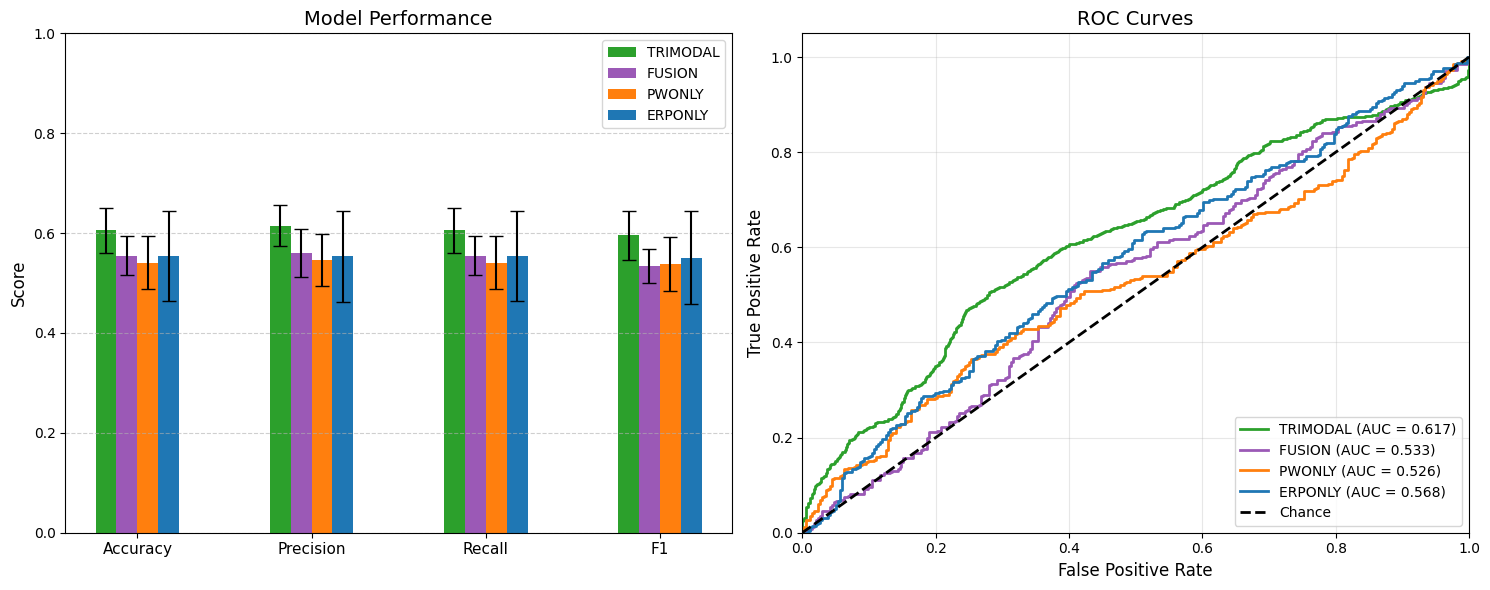

In [ ]:
logger.info("--- Generating standard metrics outputs ---")
plot_results(results, roc_all, class_names=["Good", "Poor"],save_path=config.output_dir)

In [ ]:
# Clinical saliency channel importance 
def compute_saliency(model, erp_batch, pw_batch, conn_batch, target_class, modality="trimodal"):
    model.eval()
    model.zero_grad()
    
    # 1. Prepare and Truncate
    erp_in = erp_batch.clone().detach()
    pw_in = pw_batch.clone().detach()
    conn_in = conn_batch.clone().detach()
    
    if erp_in.shape[-1] > 5000: erp_in = erp_in[:, :, :5000]
    if pw_in.shape[-1] > 5000: pw_in = pw_in[:, :, :5000]

    # 2. Enable gradients on the TRUNCATED tensors
    if modality == 'trimodal' or 'erp' in modality: erp_in.requires_grad_(True)
    if modality == 'trimodal' or 'pw' in modality: pw_in.requires_grad_(True)
    if modality == 'trimodal' or 'conn' in modality: conn_in.requires_grad_(True)
    
    if modality == "trimodal":
        logits = model(erp=erp_in, pw=pw_in, conn=conn_in)
    elif modality == "fusion": 
        logits = model(erp=erp_in, pw=pw_in)
    score = logits[:, target_class].sum()
    score.backward()
    sal_erp = erp_in.grad.abs().mean(dim=0).cpu().numpy() if erp_in.grad is not None else None
    sal_pw  = pw_in.grad.abs().mean(dim=0).cpu().numpy() if pw_in.grad is not None else None
    sal_conn = conn_in.grad.abs().mean(dim=0).cpu().numpy() if conn_in.grad is not None else None
    
    return sal_erp, sal_pw, sal_conn

In [ ]:
def generate_importance_maps(model, dataset, device):
    loader = DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=collate_trimodal)
    model.eval()
    grads = {
        'erp': {0: [], 1: []},
        'pw': {0: [], 1: []},
        'conn': {0: [], 1: []}
    }
    print("Computing tri-modal saliency maps...")
    for erp, pw, conn, subjs, ys in loader:
        erp, pw, conn = erp.to(device), pw.to(device), conn.to(device)
        for target_cls in [0, 1]:
            s_erp, s_pw, s_conn = compute_saliency(
                model, erp, pw, conn, target_class=target_cls, modality="trimodal"
            )
            if s_erp is not None: grads['erp'][target_cls].append(s_erp)
            if s_pw is not None:  grads['pw'][target_cls].append(s_pw)
            if s_conn is not None: grads['conn'][target_cls].append(s_conn)
    results = {}
    for mod in ['erp', 'pw', 'conn']:
        for c in [0, 1]:
            if grads[mod][c]:
                results[f'{mod}_class_{c}'] = np.mean(np.stack(grads[mod][c]), axis=0)

    return results

In [ ]:
# --- STATISTIC AND SALIENCY MAPS  ---
logger.info("--- Generating Statistics & Saliency Maps ---")
stats_df = perform_statistical_tests(results)
stats_df.to_csv(config.output_dir / 'statistical_tests.csv', index=False)
plot_fusion_weights_v4(results, save_path=config.output_dir)
if len(results) > 1:
    stats_df = perform_statistical_tests(results)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_erp, sample_pw, sample_conn, _, _ = trimodal_ds[0] 
#erp_ch = sample_erp.shape[0] if sample_erp.shape[0] < sample_erp.shape[1] else sample_erp.shape[1]
#pw_ch = sample_pw.shape[0]
#conn_dim = sample_conn.shape[0]
erp_ch = min(sample_erp.shape[0], sample_erp.shape[1]) 
pw_ch  = min(sample_pw.shape[0], sample_pw.shape[1]) 
conn_dim = sample_conn.shape[0]
n_classes = len(np.unique(labels_array))
logger.info(f"Saliency Model Init - ERP: {erp_ch}, PW: {pw_ch}, CONN: {conn_dim}")
model = ImprovedTriModalFusionNet(in_pw_dim=pw_ch, in_erp_dim=erp_ch, in_conn_dim=conn_dim, fusion_dim=config.fusion_dim, num_classes=n_classes).to(device)
checkpoints = list(config.checkpoint_dir.glob("best_trimodal_fold*.pt"))
if checkpoints:
    ckpt_path = checkpoints[0]
    logger.info(f"Loading best model for saliency from: {ckpt_path.name}")
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    saliency_results = generate_importance_maps(model, trimodal_ds, device)
    save_path = config.output_dir / 'saliency_maps.npy'
    np.save(save_path, saliency_results)
    logger.info(f"Saliency maps saved to {save_path}")
else:
    logger.warning("No checkpoints found. Skipping saliency generation.")
logger.info(f"Pipeline Complete. Results: {config.output_dir}")

2026-02-04 15:04:45,061 - eeg_main - INFO - --- Generating Statistics & Saliency Maps ---
2026-02-04 15:04:45,109 - eeg_main - INFO - Saliency Model Init - ERP: 18, PW: 75, CONN: 459
2026-02-04 15:04:45,198 - eeg_main - INFO - Loading best model for saliency from: best_trimodal_fold1.pt


No fusion weight data available
Computing tri-modal saliency maps...


2026-02-04 15:05:10,392 - eeg_main - INFO - Saliency maps saved to results\saliency_maps.npy
2026-02-04 15:05:10,393 - eeg_main - INFO - Pipeline Complete. Results: results


In [ ]:
# Results accessibility
if results is not None:
    print("\n" + "="*70)
    print("MODEL PERFORMANCE SUMMARY (Accuracy & F1)")
    print("="*70)
    for model_name in ["trimodal", "fusion", "pwonly", "erponly"]:
        if model_name in results and results[model_name]:
            f1_scores = [r['F1'] for r in results[model_name]]
            acc_scores = [r['Accuracy'] for r in results[model_name]]
            print(f"{model_name.upper():12s}: F1  = {np.mean(f1_scores):.4f} Â± {np.std(f1_scores):.4f}")
            print(f"{model_name.upper():12s}: ACC = {np.mean(acc_scores):.4f} Â± {np.std(acc_scores):.4f}")

if roc_all is not None:
    print("\n" + "="*70)
    print("AUC SUMMARY (Area Under ROC Curve)")
    print("="*70)
    for model_name in ["trimodal", "fusion", "pwonly", "erponly"]:
        if model_name in roc_all and roc_all[model_name]:
            auc_scores = []
            for y_true, y_probs in roc_all[model_name]:
                if y_probs.ndim == 2:
                    probs_class_1 = y_probs[:, 1]
                else:
                    probs_class_1 = y_probs
                try:
                    score = roc_auc_score(y_true, probs_class_1)
                    auc_scores.append(score)
                except ValueError:
                    auc_scores.append(0.5)
            print(f"{model_name.upper():12s}: AUC = {np.mean(auc_scores):.4f} Â± {np.std(auc_scores):.4f}")


MODEL PERFORMANCE SUMMARY (Accuracy & F1)
TRIMODAL    : F1  = 0.5953 Â± 0.0444
TRIMODAL    : ACC = 0.6058 Â± 0.0403
FUSION      : F1  = 0.5341 Â± 0.0303
FUSION      : ACC = 0.5551 Â± 0.0348
PWONLY      : F1  = 0.5375 Â± 0.0480
PWONLY      : ACC = 0.5410 Â± 0.0471
ERPONLY     : F1  = 0.5502 Â± 0.0833
ERPONLY     : ACC = 0.5543 Â± 0.0807

AUC SUMMARY (Area Under ROC Curve)
TRIMODAL    : AUC = 0.6130 Â± 0.0585
FUSION      : AUC = 0.5152 Â± 0.0824
PWONLY      : AUC = 0.5236 Â± 0.0535
ERPONLY     : AUC = 0.5471 Â± 0.1148


In [ ]:
# ========== ADVANCED INTERPRETABILITY ==========
class InterpretabilityAnalyzer:
    def __init__(self, model, device, channel_names=None):
        self.model = model.eval().to(device)
        self.device = device
        self.channels = channel_names or [f"Ch{i}" for i in range(18)]
    def compute_integrated_gradients(self, erp, pw, conn=None, target_class=1, steps=50):
        ig = IntegratedGradients(self._forward_func)
        erp_base = torch.zeros_like(erp)
        pw_base = torch.zeros_like(pw)
        if conn is not None:
            conn_base = torch.zeros_like(conn)
            attrs = ig.attribute((erp, pw, conn), (erp_base, pw_base, conn_base), target=target_class, n_steps=steps)
        else:
            attrs = ig.attribute((erp, pw), (erp_base, pw_base), target=target_class, n_steps=steps)
        return attrs

    def _forward_func(self, *inputs):
        if len(inputs) == 3:
            return self.model(inputs[0], inputs[1], inputs[2])
        return self.model(inputs[0], inputs[1])

    # Channel Importance by Ablation
    def compute_channel_importance(self, dataloader):
        """Measure importance of each channel by zeroing it out"""
        importance_erp = np.zeros(len(self.channels))
        importance_pw = np.zeros(len(self.channels))
        n_samples = 0
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Channel importance"):
                if len(batch) == 5:  
                    erp, pw, conn, subjs, ys = batch
                    conn = conn.to(self.device)
                else:
                    erp, pw, subjs, ys = batch[:4]
                    conn = None
                erp, pw = erp.to(self.device), pw.to(self.device)
                if conn is not None:
                    logits_base = self.model(erp, pw, conn)
                else:
                    logits_base = self.model(erp, pw)
                probs_base = F.softmax(logits_base, dim=1)[:, 1]

                for ch in range(erp.shape[1]):
                    erp_masked = erp.clone()
                    erp_masked[:, ch, :] = 0
                    logits = self.model(erp_masked, pw, conn) if conn is not None else self.model(erp_masked, pw)
                    probs = F.softmax(logits, dim=1)[:, 1]
                    drop = (probs_base - probs).mean().item()
                    importance_erp[ch] += drop

                for ch in range(pw.shape[1]):
                    pw_masked = pw.clone()
                    pw_masked[:, ch, :] = 0
                    logits = self.model(erp, pw_masked, conn) if conn is not None else self.model(erp, pw_masked)
                    probs = F.softmax(logits, dim=1)[:, 1]
                    drop = (probs_base - probs).mean().item()
                    importance_pw[ch] += drop
                n_samples += erp.shape[0]

        return importance_erp / n_samples, importance_pw / n_samples

    # SHAP Values
    def compute_shap(self, train_loader, test_samples, max_background=100):
        bg_data = []
        for i, batch in enumerate(train_loader):
            if i >= max_background // train_loader.batch_size:
                break
            bg_data.append((batch[0].to(self.device), batch[1].to(self.device)))

        bg_erp = torch.cat([b[0] for b in bg_data])[:max_background]
        bg_pw = torch.cat([b[1] for b in bg_data])[:max_background]

        explainer = shap.DeepExplainer(
            lambda e, p: self.model(e, p).cpu().detach().numpy(),
            [bg_erp, bg_pw]
        )

        shap_values = explainer.shap_values(test_samples)
        return shap_values

print("Interpretability analyzer defined")

Interpretability analyzer defined


In [ ]:
# ========== ENHANCED VISUALIZATIONS ==========
def plot_channel_importance(importance_erp, importance_pw, channel_names, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].barh(channel_names, importance_erp, color='skyblue')
    axes[0].set_xlabel('Importance Score', fontsize=12)
    axes[0].set_title('ERP Channel Importance', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    axes[1].barh(channel_names, importance_pw, color='coral')
    axes[1].set_xlabel('Importance Score', fontsize=12)
    axes[1].set_title('Power Channel Importance', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_trimodal_gates(gates, labels, save_path=None):
    df = pd.DataFrame({
        'ERP': gates[:, 0],
        'Power': gates[:, 1],
        'Connectivity': gates[:, 2],
        'Outcome': ['Good' if l==0 else 'Poor' for l in labels]
    })
    df_melt = df.melt(id_vars='Outcome', var_name='Modality', value_name='Weight')
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melt, x='Modality', y='Weight', hue='Outcome', palette='Set2')
    plt.title('Tri-Modal Gating Weights by Clinical Outcome', fontsize=14, fontweight='bold')
    plt.ylabel('Attention Weight', fontsize=12)
    plt.xlabel('Modality', fontsize=12)
    plt.legend(title='Outcome', fontsize=11)
    plt.grid(axis='y', alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_temporal_importance(temporal_map, time_points=None, title="Temporal Importance", save_path=None):
    if time_points is None:
        time_points = np.arange(temporal_map.shape[-1])
    mean_imp = temporal_map.mean(axis=0)
    std_imp = temporal_map.std(axis=0)
    plt.figure(figsize=(14, 4))
    plt.plot(time_points, mean_imp, linewidth=2, color='darkblue')
    plt.fill_between(time_points, mean_imp - std_imp, mean_imp + std_imp, alpha=0.3, color='lightblue')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time Point', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.grid(alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

Visualization functions defined
